# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"$= {cartesian_prod}$ (brute-force iterations!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|amount_tsh|\times |gps_height|\times |gps_coordinates|\times |wpt_name|\times |num_private|\times |basin|\times |region_code|\times |district_code|\times |subvillage|\times |region|\times |lga|\times |ward|\times |population|\times |public_meeting|\times |recorded_by|\times |permit|\times |extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |management|\times |management_group|\times |payment_type|\times |payment|\times |water_quality|\times |quality_group|\times |quantity|\times |quantity_group|\times |source|\times |source_type|\times |source_class|\times |waterpoint_type|\times |waterpoint_type_group|\times |pump_age|\times |funder|\times |installer|\times |scheme_management|\times |scheme_name|)$

$= 185794560$ (brute-force iterations!)

You read that correctly: if we do this using brute-force, that would be building (transforming) more than 185 million data sets!

That is obviously intractible.  

Consider the case when transforming both X_train and X_validation take, on average, 1 minute apiece.

There are 525600 minutes in one year.

**Doing the brute-force way would require 370 million minutes, which is about 700 years!**  LOL!

Instead, we will use a Greedy Algorithm to make this a linear problem.

## Baselining the Greedy Way - Another Exercise in Dynamic Programming

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [17]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [18]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [19]:
X_validation_baseline = X_validation[baseline_cols]

In [20]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [21]:
clf = XGBClassifier(max_depth=10, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [22]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with PRIOR best options...</h4>"))
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            
            # filter out any columns that were dropped
            filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols)))
            display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
            display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
            
            # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
            cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
            prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
            # now we need to filter out the ones not in X
            filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), filtered_transformed_feat_names)))
            filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
            display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
            display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
            
            baseline_plus_transformed_cols = filtered_baseline_cols
            if len(filtered_transformed_feat_names) > 0:
                baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)
                
            cols_prior = baseline_plus_transformed_cols
            display(HTML(f"<h5>features include from prior best modes:</h5>"))
            display(HTML(f"<pre>{X_train_priors_transformed[cols_prior].info()}</pre>"))
            
        display(HTML(f"<h5>terminal features in prior best model:</h5>"))
        display(HTML(f"<pre>{X_train_priors_transformed[cols_prior].info()}</pre>"))
    
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with option {idx+1}:</h4>"))
        composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp
        )
        scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        
        # filter out any columns that were dropped
        filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols)))
        display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
        display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
        
        # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
        cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
        prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
        # now we need to filter out the ones not in X
        filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), filtered_transformed_feat_names)))
        filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
        display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
        display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
        
        baseline_plus_transformed_cols = filtered_baseline_cols
        if len(filtered_transformed_feat_names) > 0:
            baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h5>features to be included in model:</h5>"))
        display(HTML(f"<pre>{X_train_transformed[cols_in_model].info()}</pre>"))

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=10, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'>Option {idx+1} of this preprocessing-option group yields new BEST validation accuracy (of this group of options)!</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        

        display(HTML("<p><br><br><br><br>"))

    if best[3] <= _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY ABOVE BASELINE ({_accuracy_validation_baseline})!</font></h2>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option increases accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}) is:</font></h2>"))
        display(HTML(f"<pre>{best}</pre>"))

    return best, y_acc

In [23]:
# # test out individual preprocessing groups here, for example...
# best_options = []
# y_acc = []
# find_best_option('gps_coordinates__group', 'gps_coordinates', best_options, y_acc)

strategy "leave feature as is (do nothing): amount_tsh" appended step ['leave feature as is (do nothing): amount_tsh', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31baaf950>)] to pipeline
strategy "leave feature as is (do nothing): amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e24d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b060e10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


strategy "replace "amount_tsh" values (0) with nan" appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31baaf950>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         15999 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace "amount_tsh" outliers with mean" appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc330783550>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: amount_tsh" appended step ['drop feature: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb703d0>] to pipeline
strategy "drop feature: amount_tsh" transformation of feature "amount_tsh" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   construction_year  53460 non-null  int64  
 1   district_code      53460 non-null  int64  
 2   gps_height         53460 non-null  int64  
 3   latitude           53460 non-null  float64
 4   longitude          53460 non-null  float64
 5   num_private        53460 non-null  int64  
 6   population         53460 non-null  int64  
 7   region_code        53460 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 3.7 MB


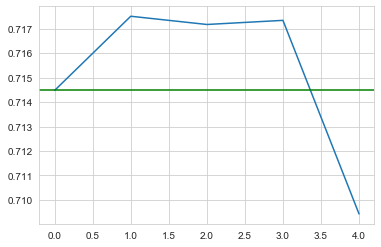

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319375050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31936e790>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b87f320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319375dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height' appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d21f7d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   latitude                   53460 non-null  float64
 3   longitude                  53460 non-null  float64
 4   num_private                53460 non-null  int64  
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
 8   gps_height_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 13 categories of 'gps_height' occur in X (out of 1717 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'gps_height' has 16 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: gps_he

strategy "drop feature: gps_height" appended step ['drop feature: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31936ef90>] to pipeline
strategy "drop feature: gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   latitude                   53460 non-null  float64
 3   longitude                  53460 non-null  float64
 4   num_private                53460 non-null  int64  
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


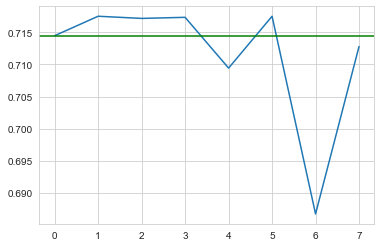

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d39d4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a0450>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b87f320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b95fa10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


strategy "drop feature: latitude" appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b956790>] to pipeline
strategy "drop feature: latitude" transformation of feature "latitude" is COMPLETE!
strategy "drop feature: longitude" appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b95f7d0>] to pipeline
strategy "drop feature: longitude" transformation of feature "longitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   num_private                53460 non-null  int64  
 4   population                 53460 non-null  int64  
 5   region_code                53460 non-null  int64  
 6   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 3.3 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


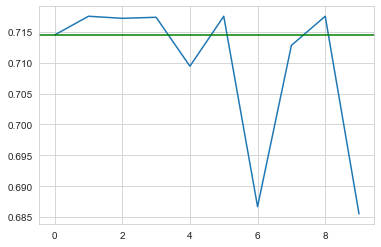

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b87f320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3c7490>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c9b90>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c917990>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319362510>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


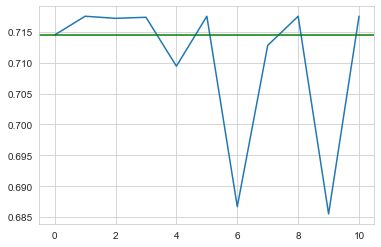

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b733f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b73fc10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b87f320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b74d310>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b752550>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e26910>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


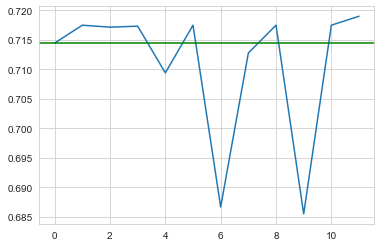

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4a1440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b46bf50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b470a70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c908b90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b48e110>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b975fd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "impute lower-case transform: basin" appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b733f80>)] to pipeline
strategy "impute lower-case transform: basin" transformation of feature "basin" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4a1dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
 8   basin_target_encoded       53460 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe7b250>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


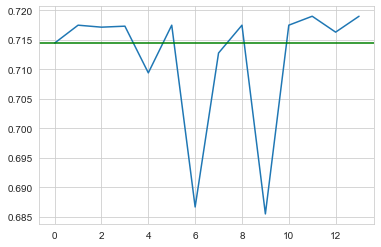

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4d8830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6d9890>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b470a70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31fe69ed0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3c0cd0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3c09d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3c0f10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe6bcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4d6390>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded


strategy "drop feature: region_code" appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6d9450>] to pipeline
strategy "drop feature: region_code" transformation of feature "region_code" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.3 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


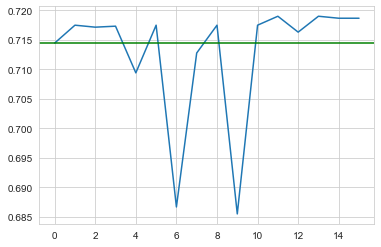

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b703ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6fed50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b470a70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c8f0c50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4d6950>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b73fe90>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b975910>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c8f4560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8cc950>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c8f4680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b7129d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: district_code" appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b712bd0>] to pipeline
strategy "drop feature: district_code" transformation of feature "district_code" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   gps_height                  53460 non-null  int64  
 2   latitude                    53460 non-null  float64
 3   longitude                   53460 non-null  float64
 4   population                  53460 non-null  int64  
 5   amount_tsh_target_encoded   53460 non-null  float64
 6   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 3.3 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded


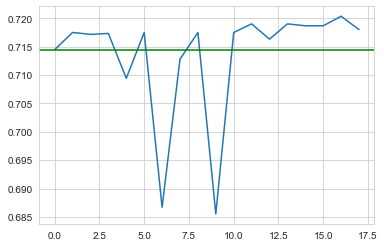

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c8f4710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe7be90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b703ef0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c8f0c50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4d6210>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c99ed10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b975590>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca1ccb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ca10990>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca1c200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b482750>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c97bd50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

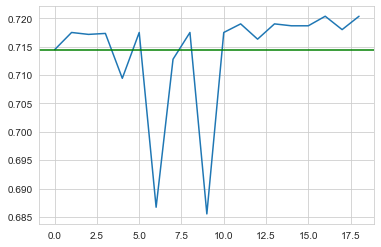

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca1ccb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8f0750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b676dd0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c99e0d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b683ed0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b683d50>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6835d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b676710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b674910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b676a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b674d90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b683490>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6743d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

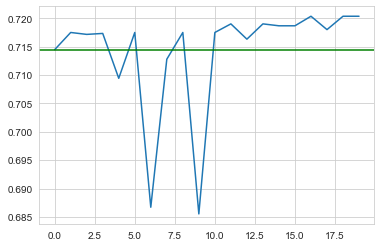

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8bcc90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b051830>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b4dce50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8d9ed0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b70bb90>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c4750>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dcb50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8bce50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c4710>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc3d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c4910>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

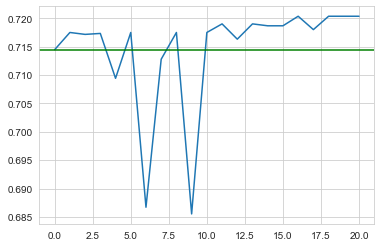

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0f950>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b488550>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e03ed0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc710>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3c0710>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc322733950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babfed0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc322733710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e035d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b06c9d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e03c50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b06ca50>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b674cd0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

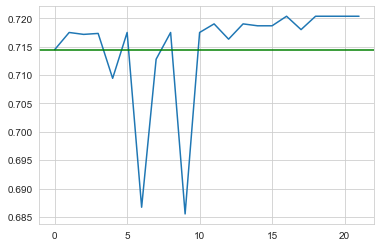

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc32272c7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc250>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc32272c830>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c9ba190>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9bac90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9bacd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9ba990>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8a89e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8d9ed0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8a88c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dca50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc710>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b06ca50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dccd0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e03850>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "leave feature as is (do nothing): population" appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050320>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8a8c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population' appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b65a350>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   amount_tsh_target_encoded     53460 non-null  float64
 5   district_code_target_encoded  53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   population_target_encoded     53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc32272cf80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31eb70290>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b96bb50>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!
strategy "replace "population" outliers with mean" appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c9baf90>] to pipeline
strategy "replace "population" outliers with mean" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "replace "population" outliers with median" appended step ['replace "population" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc319e035d0>] to pipeline
strategy "replace "population" outliers with median" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "leave feature as is (do nothing): population" appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b050320>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

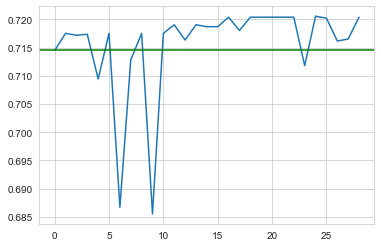

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c980290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373610>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c980c20>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc319373390>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937a250>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b9831d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b983950>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b9788c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9310>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b9787a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938e110>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319382110>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9190>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366850>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9910>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c97ef80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "replace values for feature: public_meeting" replacement_rules:
{
    "public_meeting": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy "replace values for feature: public_meeting" appended step ['replace values for feature: public_meeting', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc3193a1990>] to pipeline
strategy "replace values for feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!
strategy "leave feature as is (do nothing): public_meeting" appended step ['leave feature as is (do nothing): public_meeting', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b978b00>)] to pipeline
strategy "leave feature as is (do nothing): public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
 8   public_meeting                53460 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c99a8d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

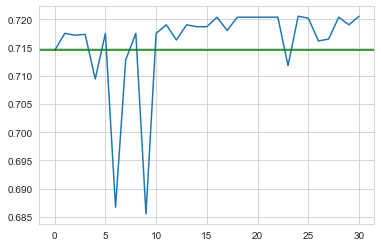

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b682f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366990>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c97ef80>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c9a9450>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ca19190>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dc950>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366b90>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca095f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9810>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca097a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b983b50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366c90>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc3193660d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b983f90>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9910>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c8f3ef0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366890>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b672550>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

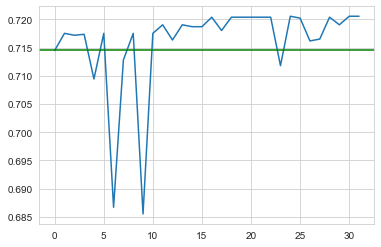

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b469170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937a5d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c8f3ef0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc319366510>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b665550>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c99a150>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b665bd0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9350>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b49c990>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366fd0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc3193664d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b497c10>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373990>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b469f80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937ae50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a90d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "replace values for feature: permit" replacement_rules:
{
    "permit": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy "replace values for feature: permit" appended step ['replace values for feature: permit', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b49abd0>] to pipeline
strategy "replace values for feature: permit" transformation of feature "permit" is COMPLETE!
strategy "leave feature as is (do nothing): permit" appended step ['leave feature as is (do nothing): permit', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de170>)] to pipeline
strategy "leave feature as is (do nothing): permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
 8   permit                        53460 non-null  bool   
dtypes: bool(1), float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b705d50>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

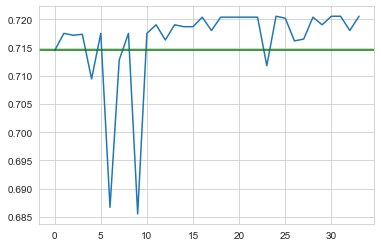

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6490e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373510>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b4c7ad0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b705b10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b705210>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c7d50>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927d50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927fd0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b497c10>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c7b50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b665bd0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b665b50>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649c20>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319391310>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927550>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6e47d0>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653150>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: extraction_type" appended step ['drop feature: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373590>] to pipeline
strategy "drop feature: extraction_type" transformation of feature "extraction_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

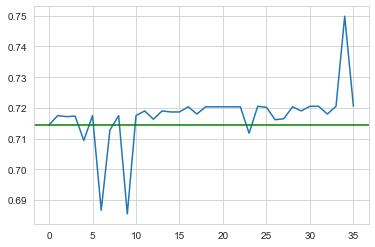

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366b10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b71a9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b497c10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4dcd10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4e2cd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b983f90>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938e590>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9274d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4910d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b665bd0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b65ab10>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373790>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de320>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe59e50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b49c8d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366b90>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b747200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6e4590>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6e4f10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

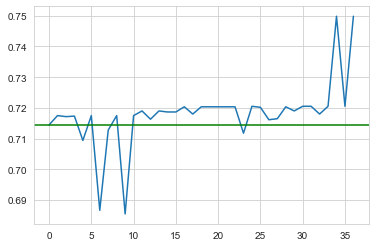

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b649c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9150>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3a57a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b6340d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d233cd0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2b90>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937aa90>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b747b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d233c50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b747200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9270d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a99d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634710>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b65ab10>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9990>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de320>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b49c8d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634810>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b724f90>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d22a200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366b90>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4e2150>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319373f90>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

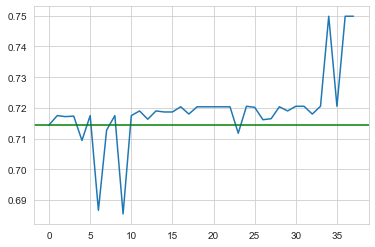

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b747200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9990>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b71a9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b4910d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937ad90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9c50>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3bdf10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86add0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86a310>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653390>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b705dd0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6f34d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9910>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6de320>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9ad0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3bd0d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86a290>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa4d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ae90>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa810>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d59d750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: management" appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3833d0>] to pipeline
strategy "drop feature: management" transformation of feature "management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

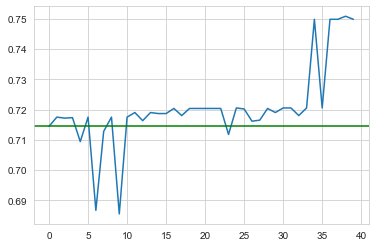

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9270d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b71a9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31d233690>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0850>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396910>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bba9910>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bbaef80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d233d50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bbaecb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937add0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bba9a50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653950>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653650>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2190>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b0ef0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b66aed0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6537d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937a390>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86b710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86aa90>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bba9fd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31937a5d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bbae050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86a710>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9990>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

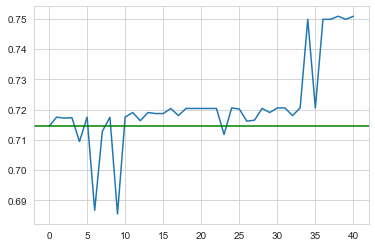

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e832b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bba9490>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f3558c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31e827a10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83ae10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83aad0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83a490>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f3557a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e827e90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f355a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83a510>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e827f50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83ab10>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83aa50>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83afd0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f355ef0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e827190>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83a550>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83a8d0>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f355440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393550>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e827e10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83ac10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f355680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393610>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e83ab50>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f355e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb855d0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: payment_type" appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393890>] to pipeline
strategy "drop feature: payment_type" transformation of feature "payment_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

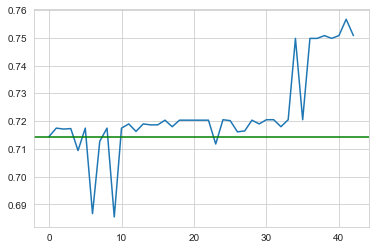

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb66d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d310>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb66950>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31d5aa410>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396850>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb6bd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927e10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb533b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b0410>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb53950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3964d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396950>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927610>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927e50>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b0550>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e832dd0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aab90>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f38ca10>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b0790>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb534d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634a10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa950>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b0590>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb53050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653f50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634a90>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eb53680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653550>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634050>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

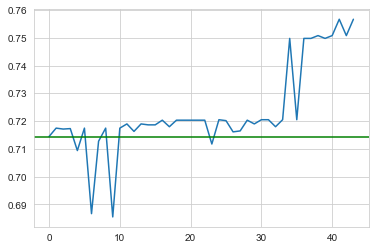

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa950>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b0609e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b634850>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc32fb42a10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319e269d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b0690>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85df90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9273d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6539d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa8d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653ad0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc32f590210>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b060dd0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b65ae10>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393cd0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d0d0>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babcbd0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babc9d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b06c390>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3963d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653150>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e189e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396550>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396810>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938e490>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: water_quality" appended step ['drop feature: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babcfd0>] to pipeline
strategy "drop feature: water_quality" transformation of feature "water_quality" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

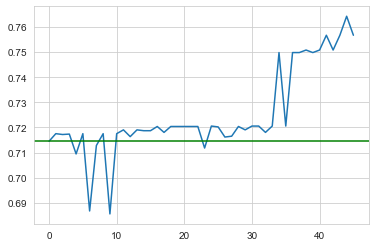

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e187a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2f10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b0609e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c927250>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927d10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb9a890>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e82da50>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927950>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d350>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e82d590>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc322702090>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393250>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9bd0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc3227125f0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927e50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babccd0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393350>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396c50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b06c390>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653d10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e856200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f3938d0>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e8567a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634150>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babc690>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e856560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634e10>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634790>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

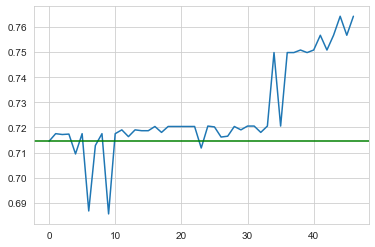

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8bb680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653350>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18d40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b634d90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9bd0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b892d10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396190>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb985f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927650>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8a50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b653790>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9279d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa8d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927810>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8bbe60>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb09d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f393490>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e81d490>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f3d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc322702c50>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938efd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f8d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8490>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f7d0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a85d0>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fcd0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb05d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb989e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8ba210>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: quantity" appended step ['drop feature: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8abd90>] to pipeline
strategy "drop feature: quantity" transformation of feature "quantity" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

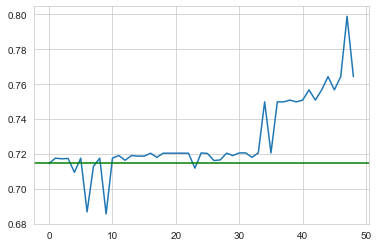

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2ad0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b993e60>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c927d10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9d90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396750>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634b10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb985f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927810>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8550>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927290>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb85710>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31babcd90>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938eed0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8bb4d0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa550>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9b10>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e857e90>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8bb680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a84d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b97d290>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b9804d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31bb98710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0a10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396f10>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fdd0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a86d0>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b9750e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fe90>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0dd0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fed0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f3d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

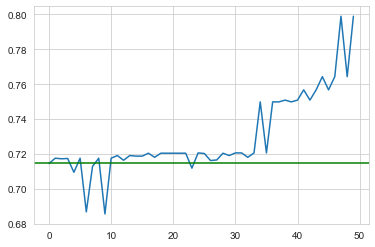

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b3f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85dd50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b8bbe60>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b634250>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5ad610>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85da10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2810>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31938ef90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396550>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5ad110>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396190>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374f10>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b396c50>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0200>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5ad2d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374ad0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393690>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0190>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b20d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0e90>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0490>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8710>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fd50>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319396410>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f490>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393510>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b980510>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2750>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c09e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e82db10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: source" appended step ['drop feature: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb82d0>] to pipeline
strategy "drop feature: source" transformation of feature "source" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

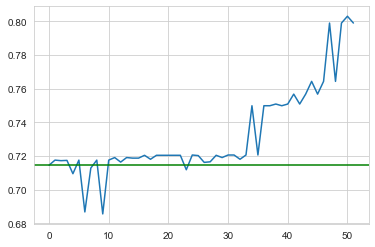

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0d10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61ca70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b8a8590>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fc50>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8750>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa950>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8a90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393b10>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9d90>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0f50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a86d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2750>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61c7a0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9a9950>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393910>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2810>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374d50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8290>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3939d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374490>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2ad0>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652d10>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374450>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f374b10>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652850>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652610>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6526d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652890>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2890>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

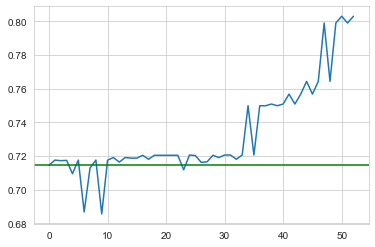

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927e50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31e857e90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6e1a10>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb6bd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9272d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d350>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fd50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f890>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d850>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc33077e050>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d250>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61ca70>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d2d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f38ce90>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8fe90>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a83d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aaa10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0a10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f850>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652b10>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a86d0>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b3c0dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652c50>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927ad0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652a90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2750>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86a3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393290>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a7810>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393a10>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

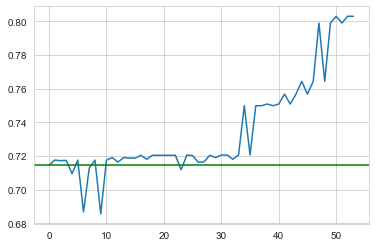

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86a3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e8d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f86a050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b726d50>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b478e90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b700790>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b755f10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99aef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aaa10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f890>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366210>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc319366fd0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d585750>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d5aa6d0>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975050>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0a50>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bb8f2d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e390>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927550>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927290>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8dd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2350>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3b2810>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393950>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc322732a90>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99a3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a86d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6f3790>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61ca70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ee90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8ab090>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c983910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b3934d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1490>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b481290>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: waterpoint_type" appended step ['drop feature: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a7c50>] to pipeline
strategy "drop feature: waterpoint_type" transformation of feature "waterpoint_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

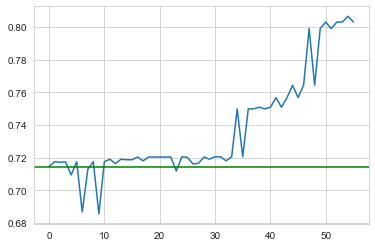

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31e81de50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61ca70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31bbb0a10>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6340d0>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634b10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b755d50>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d1fdb90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6fd5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8a8590>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b655fd0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d1fd210>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8ab090>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31bbb0590>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b975050>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d585750>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b481a90>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c983910>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994790>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1e50>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9272d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99a170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994cd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1b90>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e2d0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6f3a50>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99af80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e910>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994d10>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c99aef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e8d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994a50>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c91ecb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e990>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994c90>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c93fd90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c91edd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e110>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ea10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

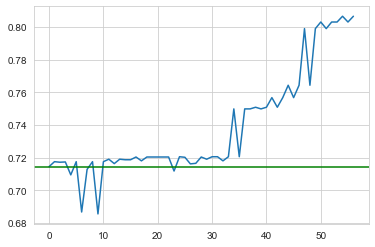

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe71cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6340d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b61ca70>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31bbb0590>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b481a90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b755f10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b8ab090>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994110>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9947d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9942d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8edad0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c93f910>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927e50>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a4d0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c91fb10>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c93f950>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1450>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5ba70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ef50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994490>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c91f850>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e910>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86eb10>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5bdd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e0d0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6e1c90>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5bcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e1d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe78f10>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5bb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe58750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e8d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe595d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe78590>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe58450>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe508d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ebd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe50b90>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5bef0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5bef0>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "replace 0 with date_recorded value: construction_year" appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5be60>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation of feature "construction_year" is COMPLETE!
strategy "convert (from string date format '%Y') to datetime type: construction_ye

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b680>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "replace 0 with date_recorded value: construction_year" appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9f4290>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation of feature "construction_year" is COMPLETE!
strategy "convert (from string date format '%Y') to datetime type: construction_ye

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gps_height                      53460 non-null  int64  
 1   latitude                        53460 non-null  float64
 2   longitude                       53460 non-null  float64
 3   population                      34150 non-null  float64
 4   amount_tsh_target_encoded       53460 non-null  float64
 5   district_code_target_encoded    53460 non-null  float64
 6   extraction_type_target_encoded  53460 non-null  float64
 7   management_target_encoded       53460 non-null  float64
 8   payment_type_target_encoded     53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe58090>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "drop feature: construction_year" appended step ['drop feature: construction_year', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe597d0>] to pipeline
strategy "drop feature: construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gps_height                      53460 non-null  int64  
 1   latitude                        53460 non-null  float64
 2   longitude                       53460 non-null  float64
 3   population                      34150 non-null  float64
 4   amount_tsh_target_encoded       53460 non-null  float64
 5   district_code_target_encoded    53460 non-null  float64
 6   extraction_type_target_encoded  53460 non-null  float64
 7   management_target_encoded       53460 non-null  float64
 8   payment_type_target_encoded     53460 non-null  float64
 9   quantity_target_encoded         53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  source_target_encoded           53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

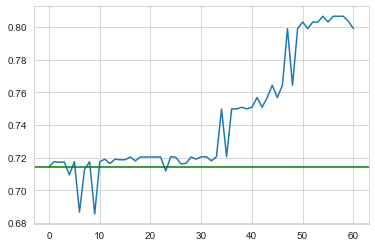

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b98ccd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe719e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31938ef90>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634a90>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b4c3cd0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ca29a10>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c983d90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1110>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c92c990>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ca29b50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b755510>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c927d10>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9f40e0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3a1310>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b634c10>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f85d310>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c70e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c994d10>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9273d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe78f10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c7950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e4d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe50710>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c7b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e610>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe50a10>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c77a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86ed10>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b6528d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f86e1d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b652990>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5ba70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c91f950>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe586d0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b62d3d0>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c7dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c91fd90>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31b393c10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c8d4fd0>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b4c7a70>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31fe5b950>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31b4bca50>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded         

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "impute lower-case transform: funder" appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b46a5f0>)] to pipeline
strategy "impute lower-case transform: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: funder" appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31fdd2dd0>] to pipeline
strategy "replace values for feature: funder" transformation of feature "funder" is COMPLETE!
strategy "replace values for feature:

strategy "tfidf kmeans classify high-cardinality string-categorical: funder" appended step ['tfidf kmeans classify high-cardinality string-categorical: funder', FunctionTransformer(func=<function C__tfidf_kmeans_classify__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9f4320>)] to pipeline


<Figure size 432x288 with 0 Axes>

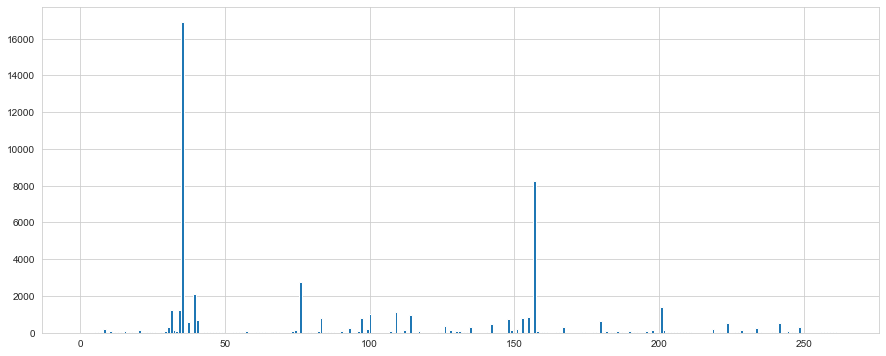

strategy "tfidf kmeans classify high-cardinality string-categorical: funder" transformation of feature "funder" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder_tfidf_kmeans_class" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder_tfidf_kmeans_class', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31ca24d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder_tfidf_kmeans_class' in X match those that were previously fit
added new feature: funder_tfidf_kmeans_class_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder_tfidf_kmeans_class' appende

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   construction_year                         53460 non-null  int64  
 1   gps_height                                53460 non-null  int64  
 2   latitude                                  53460 non-null  float64
 3   longitude                                 53460 non-null  float64
 4   population                                34150 non-null  float64
 5   amount_tsh_target_encoded                 53460 non-null  float64
 6   district_code_target_encoded              53460 non-null  float64
 7   extraction_type_target_encoded            53460 non-null  float64
 8   management_target_encoded                 53460 non-null  float64
 9   payment_type_target_encoded               53460 non-null  float64
 10  quantity_target_encoded         

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

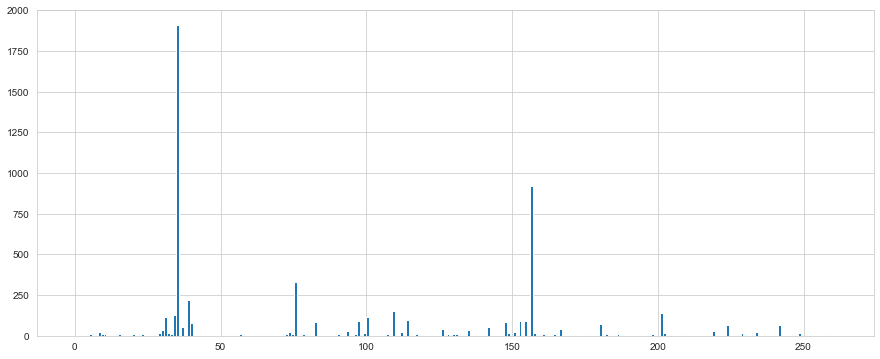

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder_tfidf_kmeans_class' in X match those that were previously fit
added new feature: funder_tfidf_kmeans_class_target_encoded


strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ec385d0>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

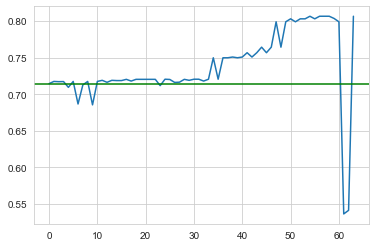

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b40e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ebafc10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b65cd40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31eb98790>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ebaf090>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe231d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ec35190>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb98e10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eba5690>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb98a50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb98f50>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eba51d0>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ec2b190>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc322861950>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb982d0>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eba5110>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eba5a50>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b49e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb884d0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb98b10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eba5490>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36b90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c983590>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36610>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb887d0>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36490>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb88750>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b48c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36b50>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb98290>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe17ed0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eb88110>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36d90>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31e8288c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe17f50>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36190>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe36890>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc322861560>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fe363d0>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4b00>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31fe36

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded         

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "impute lower-case transform: installer" appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b47a0>)] to pipeline
strategy "impute lower-case transform: installer" transformation of feature "installer" is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: installer" appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc322734

strategy "tfidf kmeans classify high-cardinality string-categorical: installer" appended step ['tfidf kmeans classify high-cardinality string-categorical: installer', FunctionTransformer(func=<function C__tfidf_kmeans_classify__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31d5b4050>)] to pipeline


<Figure size 432x288 with 0 Axes>

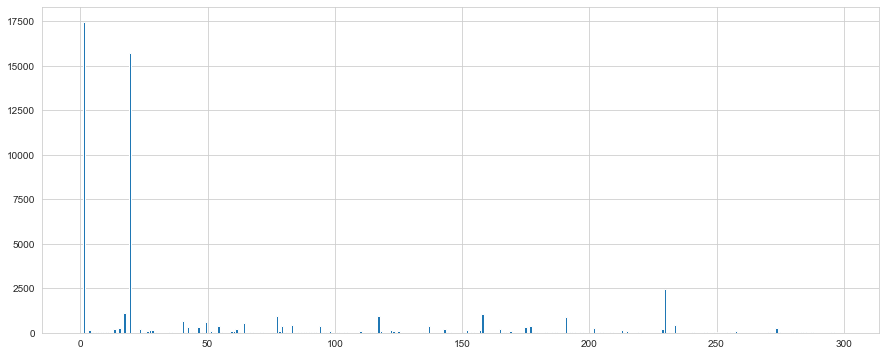

strategy "tfidf kmeans classify high-cardinality string-categorical: installer" transformation of feature "installer" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer_tfidf_kmeans_class" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer_tfidf_kmeans_class', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc3228617a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'installer_tfidf_kmeans_class' in X match those that were previously fit
added new feature: installer_tfidf_kmeans_class_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer_tfidf_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 226
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   construction_year                            53460 non-null  int64  
 1   gps_height                                   53460 non-null  int64  
 2   latitude                                     53460 non-null  float64
 3   longitude                                    53460 non-null  float64
 4   population                                   34150 non-null  float64
 5   amount_tsh_target_encoded                    53460 non-null  float64
 6   district_code_target_encoded                 53460 non-null  float64
 7   extraction_type_target_encoded               53460 non-null  float64
 8   management_target_encoded                    53460 non-null  float64
 9   payment_type_target_encoded                  53460 non-null  float64
 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

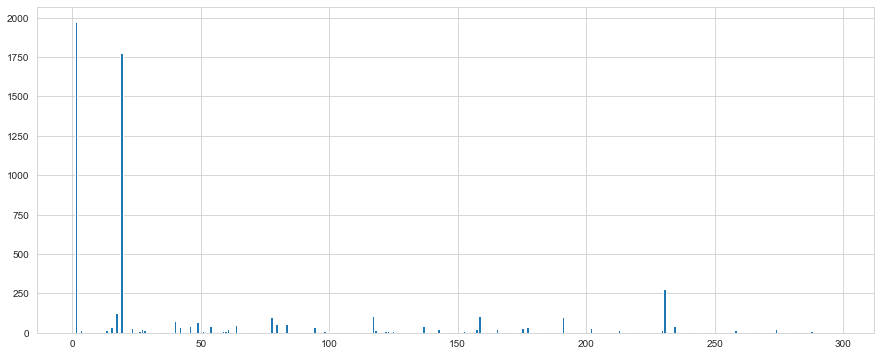

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'installer_tfidf_kmeans_class' in X match those that were previously fit
added new feature: installer_tfidf_kmeans_class_target_encoded


strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31ebc6d50>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

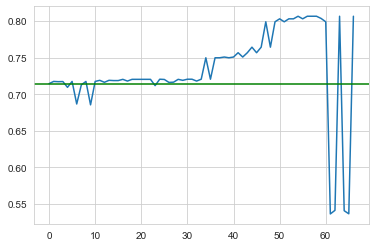

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1310>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677b90>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c9c4510>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1150>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1e10>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1ad0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6778c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c4750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd8110>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1c50>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c4d90>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c4990>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c4090>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677950>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1c90>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c48d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c47d0>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd8250>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1990>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd88d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd750>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd8550>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd7d0>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c4290>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfdfd0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd8fd0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfdd10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbd87d0>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3eaf90>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd690>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd850>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3ea890>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfdcd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd350>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b6775f0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31c9c1390>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31cbfd910>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "impute lower-case transform: scheme_management" appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31b677050>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation of feature "scheme_management" is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_management" appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31c9e6cd0>] to pipeline
strategy "replace values for feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transfor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 51357
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   construction_year                 53460 non-null  int64  
 1   gps_height                        53460 non-null  int64  
 2   latitude                          53460 non-null  float64
 3   longitude                         53460 non-null  float64
 4   population                        34150 non-null  float64
 5   amount_tsh_target_encoded         53460 non-null  float64
 6   district_code_target_encoded      53460 non-null  float64
 7   extraction_type_target_encoded    53460 non-null  float64
 8   management_target_encoded         53460 non-null  float64
 9   payment_type_target_encoded       53460 non-null  float64
 10  quantity_target_encoded           53460 non-null  float64
 11  region_code_target_encoded        53460 non-null  float64
 12  

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31f8503d0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

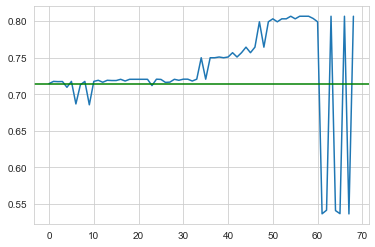

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0f170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd9afd0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31f8533b0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31fd99850>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8c190>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   num_private                53460 non-null  int64  
 6   population                 53460 non-null  int64  
 7   region_code                53460 non-null  int64  
 8   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8d250>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8dd50>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   construction_year          53460 non-null  int64  
 1   district_code              53460 non-null  int64  
 2   gps_height                 53460 non-null  int64  
 3   latitude                   53460 non-null  float64
 4   longitude                  53460 non-null  float64
 5   population                 53460 non-null  int64  
 6   region_code                53460 non-null  int64  
 7   amount_tsh_target_encoded  53460 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e184d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd99690>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   construction_year           53460 non-null  int64  
 1   district_code               53460 non-null  int64  
 2   gps_height                  53460 non-null  int64  
 3   latitude                    53460 non-null  float64
 4   longitude                   53460 non-null  float64
 5   population                  53460 non-null  int64  
 6   amount_tsh_target_encoded   53460 non-null  float64
 7   region_code_target_encoded  53460 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd929d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   region_code_target_encoded    53460 non-null  float64
 7   district_code_target_encoded  53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd99810>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd9a790>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd9a210>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd9ab10>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    53460 non-null  int64  
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 3.7 MB


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0f320>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd86d90>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd999d0>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd92d50>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   construction_year             53460 non-null  int64  
 1   gps_height                    53460 non-null  int64  
 2   latitude                      53460 non-null  float64
 3   longitude                     53460 non-null  float64
 4   population                    34150 non-null  float64
 5   amount_tsh_target_encoded     53460 non-null  float64
 6   district_code_target_encoded  53460 non-null  float64
 7   region_code_target_encoded    53460 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.7 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e183b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8f110>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   region_code_target_encoded      53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8ff10>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd92d10>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 4.1 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e180e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd96110>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   region_code_target_encoded      53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8f2d0>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 4.5 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fda0c10>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   region_code_target_encoded      53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fda0a90>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 4.9 MB


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e187a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd966d0>] to pipeline
strategy '(prefit) target-encoder (LO

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd99090>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
dtypes: float64(10), int64(2)
mem

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd96a10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  region_code_target_encoded      53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded     

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd99610>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e188c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd96e10>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  water_quality_target_encoded

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d153fd0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3e3b10>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd96dd0>] to pipeline
strategy '(prefit) target

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd92490>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31fd8d190>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e18320>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3e3410>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3e3090>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31d3e39d0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0ff80>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31fda7f50>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

strategy "impute lower-case transform: scheme_name" appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0fdd0>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy "replace values for feature: scheme_name" appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31d3b2510>] to pipeline
strategy "replace values for feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
         

strategy "tfidf kmeans classify high-cardinality string-categorical: scheme_name" appended step ['tfidf kmeans classify high-cardinality string-categorical: scheme_name', FunctionTransformer(func=<function C__tfidf_kmeans_classify__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0ff80>)] to pipeline


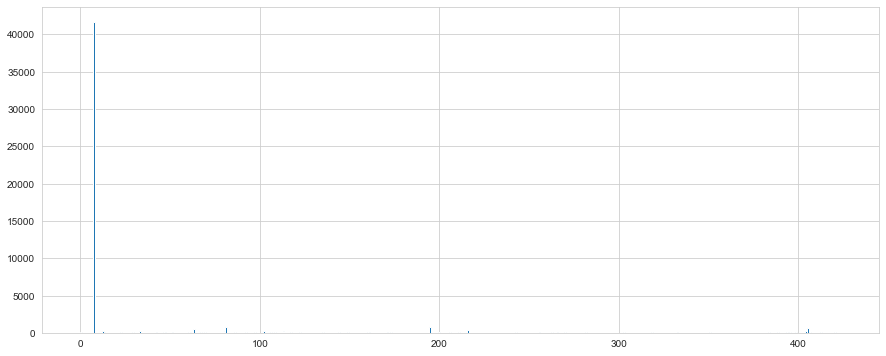

strategy "tfidf kmeans classify high-cardinality string-categorical: scheme_name" transformation of feature "scheme_name" is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name_tfidf_kmeans_class" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name_tfidf_kmeans_class', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc319e0f710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name_tfidf_kmeans_class' in X match those that were previously fit
added new feature: scheme_name_tfidf_kmeans_class_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: sche

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 47669
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   construction_year                              53460 non-null  int64  
 1   gps_height                                     53460 non-null  int64  
 2   latitude                                       53460 non-null  float64
 3   longitude                                      53460 non-null  float64
 4   population                                     34150 non-null  float64
 5   amount_tsh_target_encoded                      53460 non-null  float64
 6   district_code_target_encoded                   53460 non-null  float64
 7   extraction_type_target_encoded                 53460 non-null  float64
 8   management_target_encoded                      53460 non-null  float64
 9   payment_type_target_encoded                   

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

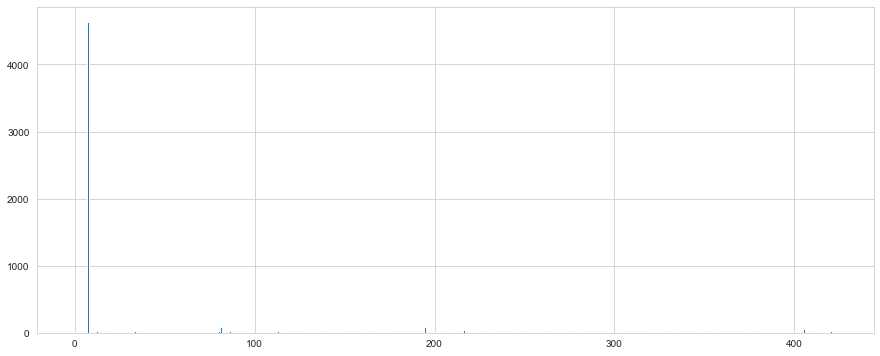

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name_tfidf_kmeans_class' in X match those that were previously fit
added new feature: scheme_name_tfidf_kmeans_class_target_encoded


strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc322875c90>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   construction_year               53460 non-null  int64  
 1   gps_height                      53460 non-null  int64  
 2   latitude                        53460 non-null  float64
 3   longitude                       53460 non-null  float64
 4   population                      34150 non-null  float64
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   district_code_target_encoded    53460 non-null  float64
 7   extraction_type_target_encoded  53460 non-null  float64
 8   management_target_encoded       53460 non-null  float64
 9   payment_type_target_encoded     53460 non-null  float64
 10  quantity_target_encoded         53460 non-null  float64
 11  region_code_target_encoded      53460 non-null  float64
 12  source_target_encoded       

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

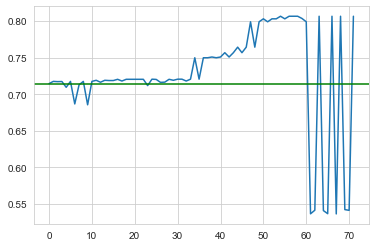

In [24]:
best_options = []
y_acc = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    plt.figure()
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option, y_acc = find_best_option(feat_group_name, preprocessing_group_name, best_options, y_acc)
        best_options.append(best_option)

        plt.plot(list(range(len(y_acc))), y_acc)
        plt.axhline(y=_accuracy_validation_baseline, color="red" if best_option[3] < _accuracy_validation_baseline else "green")
        plt.show()

        display(HTML("<p><br><br><br><br>"))

## Apply Best Preprocessing Options Transformations to `X_train`

In [25]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [26]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh' appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac43d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

strategy "leave feature as is (do nothing): gps_height" appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e18c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation of feature "gps_height" is COMPLETE!


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy "replace values for feature: latitude" appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7fc31eac66d0>] to pipeline
strategy "replace values for feature: latitude" transformation of feature "latitude" is COMPLETE!


strategy "drop feature: wpt_name" appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac3950>] to pipeline
strategy "drop feature: wpt_name" transformation of feature "wpt_name" is COMPLETE!


strategy "drop feature: num_private" appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac37d0>] to pipeline
strategy "drop feature: num_private" transformation of feature "num_private" is COMPLETE!


strategy "drop feature: basin" appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac38d0>] to pipeline
strategy "drop feature: basin" transformation of feature "basin" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code' appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac6390>] to pipeline
strategy '(prefit) target-encoder (LOO==False, po

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code' appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac4d50>] to pipeline
strategy '(prefit) target-encoder (LO

strategy "drop feature: subvillage" appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac69d0>] to pipeline
strategy "drop feature: subvillage" transformation of feature "subvillage" is COMPLETE!


strategy "drop feature: region" appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac68d0>] to pipeline
strategy "drop feature: region" transformation of feature "region" is COMPLETE!


strategy "drop feature: lga" appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac4290>] to pipeline
strategy "drop feature: lga" transformation of feature "lga" is COMPLETE!


strategy "drop feature: ward" appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac6950>] to pipeline
strategy "drop feature: ward" transformation of feature "ward" is COMPLETE!


strategy "replace "population" values (0) with nan" appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e19e0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation of feature "population" is COMPLETE!


strategy "drop feature: public_meeting" appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac4790>] to pipeline
strategy "drop feature: public_meeting" transformation of feature "public_meeting" is COMPLETE!


strategy "drop feature: recorded_by" appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac3c10>] to pipeline
strategy "drop feature: recorded_by" transformation of feature "recorded_by" is COMPLETE!


strategy "drop feature: permit" appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac6c50>] to pipeline
strategy "drop feature: permit" transformation of feature "permit" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type' appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac06d0>] to pipeline
strategy '(prefit) target

strategy "drop feature: extraction_type_group" appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac3410>] to pipeline
strategy "drop feature: extraction_type_group" transformation of feature "extraction_type_group" is COMPLETE!


strategy "drop feature: extraction_type_class" appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac4610>] to pipeline
strategy "drop feature: extraction_type_class" transformation of feature "extraction_type_class" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management' appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac0410>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_enc

strategy "drop feature: management_group" appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eacc090>] to pipeline
strategy "drop feature: management_group" transformation of feature "management_group" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type' appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac0d10>] to pipeline
strategy '(prefit) target-encoder (LOO==Fal

strategy "drop feature: payment" appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eacc110>] to pipeline
strategy "drop feature: payment" transformation of feature "payment" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31c9e1ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality' appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9b10>] to pipeline
strategy '(prefit) target-encoder (LO

strategy "drop feature: quality_group" appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac01d0>] to pipeline
strategy "drop feature: quality_group" transformation of feature "quality_group" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eaff4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity' appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9610>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_

strategy "drop feature: quantity_group" appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac0110>] to pipeline
strategy "drop feature: quantity_group" transformation of feature "quantity_group" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eaff200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source' appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab91d0>] to pipeline
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean=

strategy "drop feature: source_type" appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac0fd0>] to pipeline
strategy "drop feature: source_type" transformation of feature "source_type" is COMPLETE!


strategy "drop feature: source_class" appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eac0f10>] to pipeline
strategy "drop feature: source_class" transformation of feature "source_class" is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eaff5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy '(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type' appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab8d10>] to pipeline
strategy '(prefit) target

strategy "drop feature: waterpoint_type_group" appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9e90>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation of feature "waterpoint_type_group" is COMPLETE!


strategy "drop feature: date_recorded" appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9110>] to pipeline
strategy "drop feature: date_recorded" transformation of feature "date_recorded" is COMPLETE!
strategy "leave feature as is (do nothing): construction_year" appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7fc31eaff050>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation of feature "construction_year" is COMPLETE!


strategy "drop feature: funder" appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9a10>] to pipeline
strategy "drop feature: funder" transformation of feature "funder" is COMPLETE!


strategy "drop feature: installer" appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9450>] to pipeline
strategy "drop feature: installer" transformation of feature "installer" is COMPLETE!


strategy "drop feature: scheme_management" appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9dd0>] to pipeline
strategy "drop feature: scheme_management" transformation of feature "scheme_management" is COMPLETE!


strategy "drop feature: scheme_name" appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fc31eab9e10>] to pipeline
strategy "drop feature: scheme_name" transformation of feature "scheme_name" is COMPLETE!


In [27]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [28]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'amount_tsh': [['amount_tsh',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'gps_height': [['gps_height', 'C__leave_it_as_is__StrategyTransformer']],
 'gps_coordinates': [['gps_coordinates',
   'C__required_proprocessing__gps_coordinates__StrategyTransformer']],
 'wpt_name': [['wpt_name', 'C__drop_it__StrategyTransformer']],
 'num_private': [['num_private', 'C__drop_it__StrategyTransformer']],
 'basin': [['basin', 'C__drop_it__StrategyTransformer']],
 'region_code': [['region_code',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'district_code': [['district_code',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'subvillage': [['subvillage', 'C__drop_it__StrategyTransformer']],
 'region': [['region', 'C__drop_it__StrategyTransformer']],
 'lga': [['lga', 'C__drop_it__StrategyTransformer']],
 'ward': [['ward', 'C__drop_it__StrategyTransformer']],
 'population': [[

In [29]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [30]:
fname__preprocessing_options_cfg = WRANGLED_DATA_DIR + scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
print(f"best preprocessing options config will be saved to: {fname__preprocessing_options_cfg}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-6bf01c660ea581ad7f19f5c1ec8aefac.json


In [31]:
fm.save_json(best_preprocessing_config, f"{fname__preprocessing_options_cfg}")
print(f"updated {fname__preprocessing_options_cfg}")

updated preprocessing-results/preprocessing-options-6bf01c660ea581ad7f19f5c1ec8aefac.json


In [32]:
fname__train_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(preprocessing_config, best_preprocessing_config, data_kwargs={'is_labels':False,'type':'train'})
print(f"wrangled/preprocessed training predictors will be saved to: {fname__train_predictors}")
fname__train_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(preprocessing_config, best_preprocessing_config, data_kwargs={'is_labels':True,'type':'train'})
print(f"training labels will be saved to: {fname__train_labels}")

fname__validation_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(preprocessing_config, best_preprocessing_config, data_kwargs={'is_labels':False,'type':'test'})
print(f"wrangled/preprocessed validation predictors will be saved to: {fname__validation_predictors}")
fname__validation_labels = SAVE_LABELS_DIR + scjpnutils.get_data_fname(preprocessing_config, best_preprocessing_config, data_kwargs={'is_labels':True,'type':'test'})
print(f"validation labels will be saved to: {fname__validation_labels}")

fname__unlabeled_predictors = WRANGLED_DATA_DIR + scjpnutils.get_data_fname(preprocessing_config, best_preprocessing_config, data_kwargs={'is_labels':False,'type':'unlabeled'})
print(f"wrangled/preprocessed unlabeled predictors will be saved to: {fname__unlabeled_predictors}")

wrangled/preprocessed training predictors will be saved to: preprocessing-results/wrangled-labeled-data-train-6bf01c660ea581ad7f19f5c1ec8aefac.csv
training labels will be saved to: preprocessing-results/labels-train-6bf01c660ea581ad7f19f5c1ec8aefac.csv
wrangled/preprocessed validation predictors will be saved to: preprocessing-results/wrangled-labeled-data-test-6bf01c660ea581ad7f19f5c1ec8aefac.csv
validation labels will be saved to: preprocessing-results/labels-test-6bf01c660ea581ad7f19f5c1ec8aefac.csv
wrangled/preprocessed unlabeled predictors will be saved to: preprocessing-results/wrangled-unlabeled-data-6bf01c660ea581ad7f19f5c1ec8aefac.csv


In [33]:
X_train_preprocessed.index

Int64Index([56146, 38945, 11841,  1186, 36420, 57631, 14207, 51349, 57940,
            49053,
            ...
            21005,  7817, 68674, 14096, 55895, 67998, 47669,  1071, 19703,
            70556],
           dtype='int64', name='id', length=53460)

In [34]:
y_train.index

Int64Index([56146, 38945, 11841,  1186, 36420, 57631, 14207, 51349, 57940,
            49053,
            ...
            21005,  7817, 68674, 14096, 55895, 67998, 47669,  1071, 19703,
            70556],
           dtype='int64', name='id', length=53460)

In [35]:
X_train_preprocessed_index_sorted = X_train_preprocessed.sort_index()
X_train_preprocessed_index_sorted.index

Int64Index([    0,     1,     2,     3,     5,     7,     8,     9,    11,
               12,
            ...
            74235, 74236, 74237, 74238, 74239, 74240, 74242, 74243, 74246,
            74247],
           dtype='int64', name='id', length=53460)

In [36]:
y_train_index_sorted = y_train.sort_index()
y_train_index_sorted.index

Int64Index([    0,     1,     2,     3,     5,     7,     8,     9,    11,
               12,
            ...
            74235, 74236, 74237, 74238, 74239, 74240, 74242, 74243, 74246,
            74247],
           dtype='int64', name='id', length=53460)

In [37]:
data_train = pd.concat([X_train_preprocessed_index_sorted, y_train_index_sorted], axis=1, join='inner').sort_index()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 0 to 74247
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gps_height                      53460 non-null  int64  
 1   longitude                       53460 non-null  float64
 2   latitude                        53460 non-null  float64
 3   population                      34150 non-null  float64
 4   construction_year               53460 non-null  int64  
 5   amount_tsh_target_encoded       53460 non-null  float64
 6   region_code_target_encoded      53460 non-null  float64
 7   district_code_target_encoded    53460 non-null  float64
 8   extraction_type_target_encoded  53460 non-null  float64
 9   management_target_encoded       53460 non-null  float64
 10  payment_type_target_encoded     53460 non-null  float64
 11  water_quality_target_encoded    53460 non-null  float64
 12  quantity_target_encoded         

In [38]:
data_train.drop(['status_group'], axis=1).to_csv(fname__train_predictors, sep=',')
print(f"updated {fname__train_predictors}")

updated preprocessing-results/wrangled-labeled-data-train-6bf01c660ea581ad7f19f5c1ec8aefac.csv


In [39]:
data_train[['status_group']].to_csv(fname__train_labels, sep=',')
print(f"updated {fname__train_labels}")

updated preprocessing-results/labels-train-6bf01c660ea581ad7f19f5c1ec8aefac.csv


## Apply Best Preprocessing Options Transformations (using the `Pipeline`) to `X_validation`

In [40]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [41]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

In [42]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

In [43]:
X_validation_preprocessed.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [44]:
y_validation.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [45]:
X_validation_preprocessed_index_sorted = X_validation_preprocessed.sort_index()
X_validation_preprocessed.index

Int64Index([ 3746,  6544, 28265, 49830, 16680,  6871, 61612, 29110,    66,
            28672,
            ...
            69201,  6205, 21747, 26212, 17364, 36183, 60526, 73729, 17620,
            32518],
           dtype='int64', name='id', length=5940)

In [46]:
y_validation_index_sorted = y_validation.sort_index()
y_validation_index_sorted.index

Int64Index([    4,     6,    40,    41,    46,    66,    75,    84,    96,
              105,
            ...
            74140, 74145, 74158, 74166, 74177, 74195, 74199, 74214, 74215,
            74229],
           dtype='int64', name='id', length=5940)

In [47]:
data_validation = pd.concat([X_validation_preprocessed_index_sorted, y_validation_index_sorted], axis=1, join='inner').sort_index()
data_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5940 entries, 4 to 74229
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gps_height                      5940 non-null   int64  
 1   longitude                       5940 non-null   float64
 2   latitude                        5940 non-null   float64
 3   population                      3869 non-null   float64
 4   construction_year               5940 non-null   int64  
 5   amount_tsh_target_encoded       5940 non-null   float64
 6   region_code_target_encoded      5940 non-null   float64
 7   district_code_target_encoded    5940 non-null   float64
 8   extraction_type_target_encoded  5940 non-null   float64
 9   management_target_encoded       5940 non-null   float64
 10  payment_type_target_encoded     5940 non-null   float64
 11  water_quality_target_encoded    5940 non-null   float64
 12  quantity_target_encoded         5

In [48]:
data_validation.drop(['status_group'], axis=1).to_csv(fname__validation_predictors, sep=',')
print(f"updated {fname__validation_predictors}")

updated preprocessing-results/wrangled-labeled-data-test-6bf01c660ea581ad7f19f5c1ec8aefac.csv


In [49]:
data_validation[['status_group']].to_csv(fname__validation_labels, sep=',')
print(f"updated {fname__validation_labels}")

updated preprocessing-results/labels-test-6bf01c660ea581ad7f19f5c1ec8aefac.csv


## Apply Best Preprocessing Options Transformations (using the `Pipeline`) to `X_unlabeled`

In [50]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [51]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 4 categories of 'amount_tsh' occur in X (out of 68 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 6 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_en

In [52]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

In [53]:
data_unlabeled = pd.concat([X_unlabeled_preprocessed]).sort_index()
data_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 10 to 74249
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gps_height                      14850 non-null  int64  
 1   longitude                       14850 non-null  float64
 2   latitude                        14850 non-null  float64
 3   population                      9397 non-null   float64
 4   construction_year               14850 non-null  int64  
 5   amount_tsh_target_encoded       14850 non-null  float64
 6   region_code_target_encoded      14850 non-null  float64
 7   district_code_target_encoded    14850 non-null  float64
 8   extraction_type_target_encoded  14850 non-null  float64
 9   management_target_encoded       14850 non-null  float64
 10  payment_type_target_encoded     14850 non-null  float64
 11  water_quality_target_encoded    14850 non-null  float64
 12  quantity_target_encoded        

In [54]:
data_unlabeled.to_csv(fname__unlabeled_predictors, sep=',')
print(f"updated {fname__unlabeled_predictors}")

updated preprocessing-results/wrangled-unlabeled-data-6bf01c660ea581ad7f19f5c1ec8aefac.csv
